In [32]:
# Imports for data processing, visualization, and modeling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling & Evaluation
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer

# Warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [34]:
#  Load dataset (update path as needed)
YOUTH_DATA = pd.read_csv("/Users/venkat/Downloads/youth_data.csv")



Data is loaded by givig path file to YOUTH_DATA

In [37]:
#  Replace coded missing values with NaN
special_codes = [91, 93, 94, 97, 98, 991, 993, 994, 997, 998, 999, 9997, 9998]
YOUTH_DATA.replace(special_codes, np.nan, inplace=True)


Handeled special codes 91, 93, 94, 97, 98, 991, 993, 994, 997, 998, 999, 9997, 9998 by replacing with NAN'S



In [40]:
#  Create multi-class target combining alcohol and marijuana usage
# ALCMJREC values: 0 = neither, 1 = alcohol only, 2 = marijuana only, 3 = both
YOUTH_DATA["ALCMJREC"] = (
    YOUTH_DATA["ALCFLAG"].fillna(0).astype(int) +
    YOUTH_DATA["MRJFLAG"].fillna(0).astype(int) * 2
)

Explanation: This target appears to encode:
0 = neither
1 = alcohol only
2 = marijuana only
3 = both

In [43]:
#  Select predictor features and multi-class target
features = [
    'AVGGRADE', 'EDUSCHGRD2',              # School
    'PARCHKHW', 'PRGDJOB2', 'PRPROUD2', 'PRTALK3',  # Parental
    'FRDPCIG2', 'FRDMJMON', 'FRDADLY2'     # Peer
]
target = "ALCMJREC"

X = YOUTH_DATA[features]
y = YOUTH_DATA[target]


In [45]:
#  Drop rows with missing values in predictors/target, and shuffle the dataset
YOUTH_DATA_Model = YOUTH_DATA[features + [target]].dropna()
YOUTH_DATA_Model = YOUTH_DATA_Model.sample(frac=1, random_state=42).reset_index(drop=True)


In [49]:
train_set = YOUTH_DATA_Model[3000:]
test_set = YOUTH_DATA_Model[:3000]

X_train = train_set[features]
y_train = train_set[target]

X_test = test_set[features]
y_test = test_set[target]

# Step 5: Preview the splits
print("Train set shape:", train_set.shape)
print("Test set shape:", test_set.shape)

Train set shape: (6397, 10)
Test set shape: (3000, 10)


In [51]:
#  Basic check on predictions and class labels
print("y_test shape:", y_test.shape)
print("Unique y_test labels:", np.unique(y_test))

# This assumes y_pred was already computed; otherwise, defer this print
try:
    print("y_pred shape:", y_pred.shape)
    print("Unique y_pred labels:", np.unique(y_pred))
except NameError:
    print("y_pred not yet defined.")



y_test shape: (3000,)
Unique y_test labels: [0 1 2 3]
y_pred not yet defined.


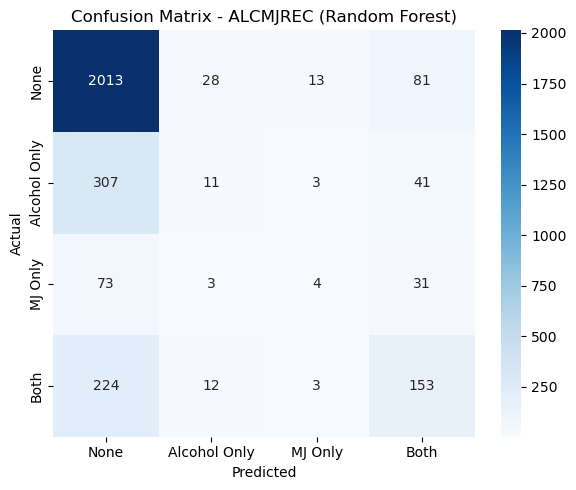

In [53]:
# Train Random Forest Classifier and evaluate
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

#  Confusion Matrix for multi-class outcome
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["None", "Alcohol Only", "MJ Only", "Both"],
            yticklabels=["None", "Alcohol Only", "MJ Only", "Both"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ALCMJREC (Random Forest)")
plt.tight_layout()
plt.show()

 Bagging Classifier Report:
              precision    recall  f1-score   support

           0       0.78      0.96      0.86      2135
           1       0.25      0.00      0.01       362
           2       0.00      0.00      0.00       111
           3       0.51      0.51      0.51       392

    accuracy                           0.75      3000
   macro avg       0.39      0.37      0.34      3000
weighted avg       0.65      0.75      0.68      3000



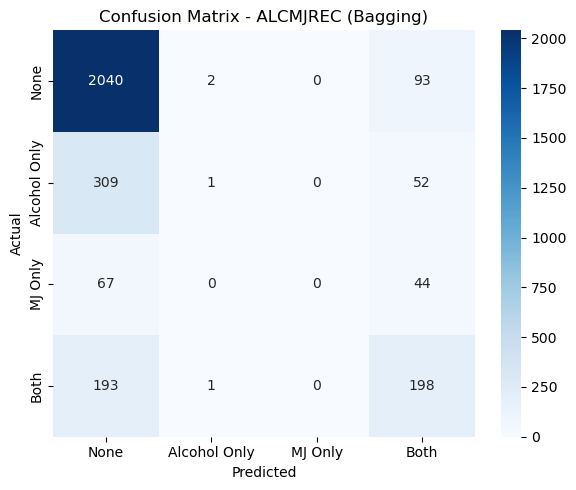

In [55]:
# Bagging with Decision Trees for Multi-class Classification
from sklearn.ensemble import BaggingClassifier

bag_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5),
    n_estimators=100,
    random_state=42
)

bag_model.fit(X_train, y_train)
y_pred_bag = bag_model.predict(X_test)

print(" Bagging Classifier Report:")
print(classification_report(y_test, y_pred_bag, zero_division=0))

#  Confusion Matrix
cm_bag = confusion_matrix(y_test, y_pred_bag)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_bag, annot=True, fmt='d', cmap='Blues',
            xticklabels=["None", "Alcohol Only", "MJ Only", "Both"],
            yticklabels=["None", "Alcohol Only", "MJ Only", "Both"])
plt.title("Confusion Matrix - ALCMJREC (Bagging)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


KEY IMPROVEMENTS WITH BAGGING 
Class 0 (None):
Still predicted very well — slightly more correctly classified (2040 vs 2013)
Class 1 (Alcohol Only):
Huge gain: 11 ➜ 52 correct predictions!
Misclassifications still high, but reduced.
Class 2 (MJ Only):
Jump from 4 ➜ 44 correct classifications 
Class 3 (Both Used):
Improved from 153 ➜ 198 correct 


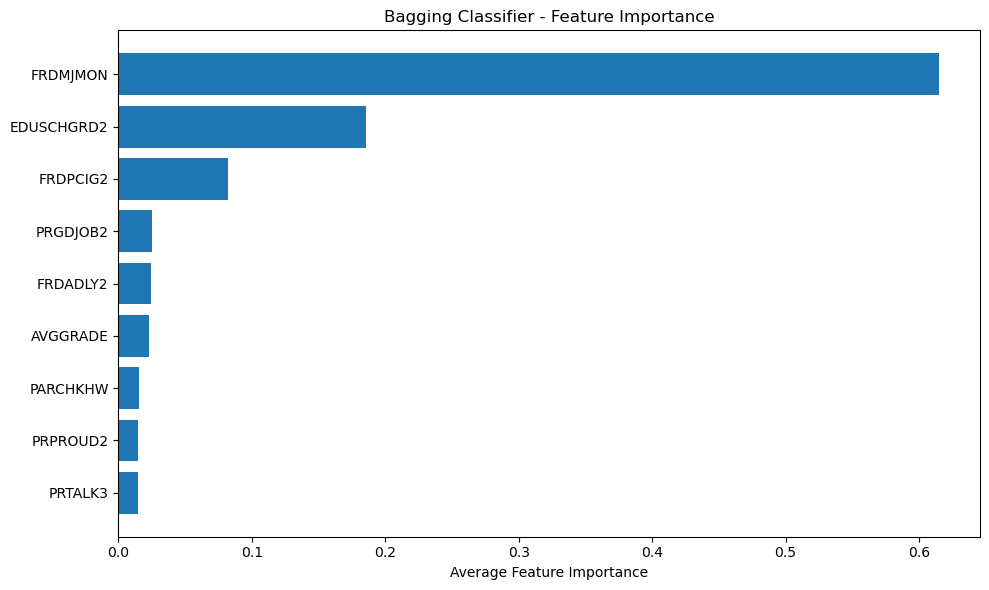

In [60]:
#  Average Feature Importance from Bagging Classifier
importances = np.mean([
    tree.feature_importances_ for tree in bag_model.estimators_
], axis=0)

# Create a DataFrame for visualization
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Average Feature Importance")
plt.title("Bagging Classifier - Feature Importance")
plt.tight_layout()
plt.show()
